# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [49]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Import Black-Scholes Functions
%run functions_black_scholes.py
import types

## Functions

In [83]:
def sigma_option(sig_model, dim1, dim2, value=0.3):
    """
    Function to generate a sigma value based on the model specified
        constant: returns a constant value
        choice: returns a random choice of three values with specified probabilities
        normal: returns a normally distributed value around the specified value

        The default value is 0.3, which is a common volatility estimate.
    """
    if sig_model == 'constant':
        return value
    elif sig_model == 'choice':
        return np.random.choice([value*(2/3),value,value*1.5], p = [.5, .3, .2], size = (dim1, dim2))
    elif sig_model == 'normal':
        return np.random.normal(loc = value, scale = value/3, size=(dim1, dim2))

In [6]:
def stock_path_constant_sigma(S0, t, r, mu, n_paths, n_steps, sigma=0.3):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    sigma (float): constant volatility of log-returns
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths

In [7]:
def stock_path_3sigmas(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths

In [85]:
def stock_path_normal_sigma(S0, t, r, mu, n_paths, n_steps, sigma):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    The sigma distribution is normal with mean .3 and standard deviation .1.
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.normal(loc = sigma, scale = sigma/3, size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths

In [51]:
def heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, mu=0, n_sims=1):
    """
    Simulation of stock path movements under the Heston stochastic volatility model.
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - mu (float): Drift component (excess return above r)
    - n_sims (int): Number of simulated paths

    Returns:
    - paths (ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1)
    """
    dt = t / n_steps
    N1 = np.random.normal(0, 1, size=(n_sims, n_steps))
    N2 = np.random.normal(0, 1, size=(n_sims, n_steps))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    paths = np.zeros((n_sims, n_steps + 1))
    vols = np.zeros((n_sims, n_steps + 1))
    paths[:, 0] = S0
    vols[:, 0] = v0

    for i in range(n_steps):
        vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
                                xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
        paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * vols[:, i]) * dt +
                                               np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
    
    return paths, vols


In [ ]:
def heston_sigma(v0, t, n_steps, kappa, theta, xi, n_sims=1, i=0, vols=None):
    """
    Simulation of stock path movements under the Heston stochastic volatility model.
    
    Parameters:
    - v0 (float): Initial variance
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - n_sims (int): Number of simulated paths
    - i (int): Current step index (default is 0)
    - vols (ndarray): Precomputed volatility paths (optional, used for recursive calls)

    Returns:
    - sigma (ndarray): Simulated volatility paths of shape (n_sims, n_steps)
    """
    dt = t / n_steps
    N1 = np.random.normal(0, 1, size=(n_sims, n_steps))

    if i == 1:
        vols = np.zeros((n_sims, n_steps))
        vols[:, 0] = v0
    else:
        vols[:, i-1] = np.abs(vols[:, i-2] + kappa * (theta - vols[:, i-2]) * dt +
                                xi * np.sqrt(np.maximum(vols[:, i-2], 0) * dt) * N1[:, i-2])

    #for i in range(n_steps-1):
    #    vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
    #                            xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
       
    return np.sqrt(vols)


In [ ]:
def bs_MC_call_paths(S0, K, sigma, t, r, paths, n_hedges = 50, delta_sims = 250, sig_model='constant'):
    
    """Description
    Monte-Carlo simulation of the Black-Scholes value of a call option with Delta based control variants
    
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (np.array): volatility array of shape (n_sims, n_hedges)
    r (float): risk-free interest rate
    t (float): time to expiration
    paths (np.array): simulated stock paths of shape (n_sims, n_hedges)
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): number of delta control variants at evenly spaced increments
    
    
    Return:
    np.array of simulated values of Black-Scholes value of call option
    """
    #time interval between each step in simulated path
    dt = t/n_hedges

    #Simulate call payouts discounted to time 0

    path_end_points = paths[:,-1]

    call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)



    #Simulate stock profits at each interval

    ## profit from start to first step discounted to time 0
    ### We are going to cheat at the current moment in our simulation
    ### We will use the Black-Scholes formula to find Delta,
    ### We'll simulate Delta later
    if sig_model == 'heston':
        sigma = np.mean(sigma)
    else:
        sigma = sigma_option(sig_model, delta_sims, 1)
    delta_start = bs_MC_call_delta(S0,K,sigma,t,r,delta_sims)

    paths_first_steps = paths[:,0]

    first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*delta_start*np.exp(-dt*r)

    stock_profits = []

    stock_profits.append(first_stock_profits)




    ## stock profits in intermediate steps

    for i in range(1,n_hedges):
        stock_start = paths[:,i-1]
        stock_end = paths[:,i]
        tte = t-i*dt
        if sig_model == 'heston':
            kappa = 4
            xi = 0.5
            theta = 0.45**2
            v0 = sigma**2
            sigma = heston_sigma(v0, tte, len(stock_start), kappa, theta, xi, delta_sims,i=i,vols=sigma)
        else:
             sigma = sigma_option(sig_model, delta_sims, len(stock_start))
        deltas = bs_MC_call_delta_array(stock_start, K, sigma, tte, r, delta_sims)


        stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)


        stock_profits.append(stock_profit)


    total_stock_profit = np.sum(stock_profits, axis = 0)

    profits_hedged = call_payouts - total_stock_profit
    
    
    return profits_hedged

## Stock Path Models

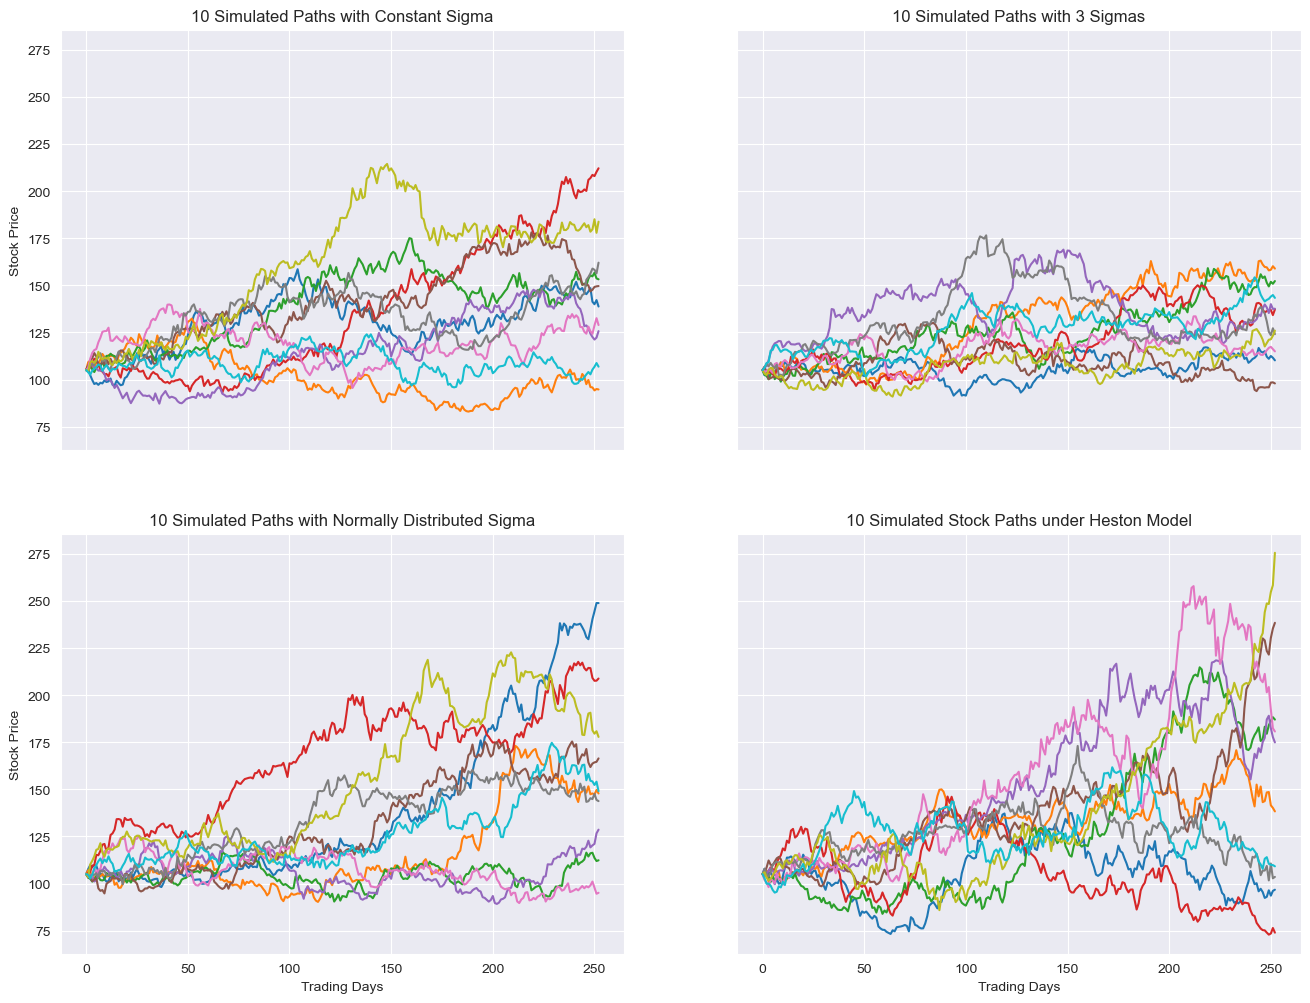

<Figure size 640x480 with 0 Axes>

In [ ]:
#10 Simulated paths of daily steps over 1-year period and plot
S0 = 105 # Initial stock price
t = 1 # Time period in years
r = 0.04 # Risk-free interest rate
mu = 0.275 # Drift of log-returns
n_paths = 10 # Number of simulated paths
n_steps = 252 # Number of trading days
# Heston parameters
kappa = 4 
theta = .45**2
xi = .5
v0 = 0.3**2
rho = -0.05
dt = t / n_steps

# Generate stock paths using different models for varying volatility
constant_paths = stock_path_constant_sigma(S0, t, r, mu, n_paths, n_steps)
sigma3_paths = stock_path_3sigmas(S0, t, r, mu, n_paths, n_steps)
normal_paths = stock_path_normal_sigma(S0, t, r, mu, n_paths, n_steps)
paths, vols = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, mu, n_paths)

# Plotting the simulated paths
fig, ax = plt.subplots(2,2, figsize=(16, 12), sharex=True, sharey=True)

for path in constant_paths:
    ax[0,0].plot(path)
for path in sigma3_paths:
    ax[0,1].plot(path)
for path in normal_paths:
    ax[1,0].plot(path)
for path in paths:
    ax[1,1].plot(path)
    
ax[0,0].set_title(f'{n_paths} Simulated Paths with Constant Sigma')
ax[0,0].set_ylabel('Stock Price')
ax[0,1].set_title(f'{n_paths} Simulated Paths with 3 Sigmas')
ax[1,0].set_title(f'{n_paths} Simulated Paths with Normally Distributed Sigma')
ax[1,0].set_ylabel('Stock Price')
ax[1,0].set_xlabel('Trading Days')
ax[1,1].set_title(f'{n_paths} Simulated Stock Paths under Heston Model')
ax[1,1].set_xlabel('Trading Days')

plt.show()
plt.tight_layout()

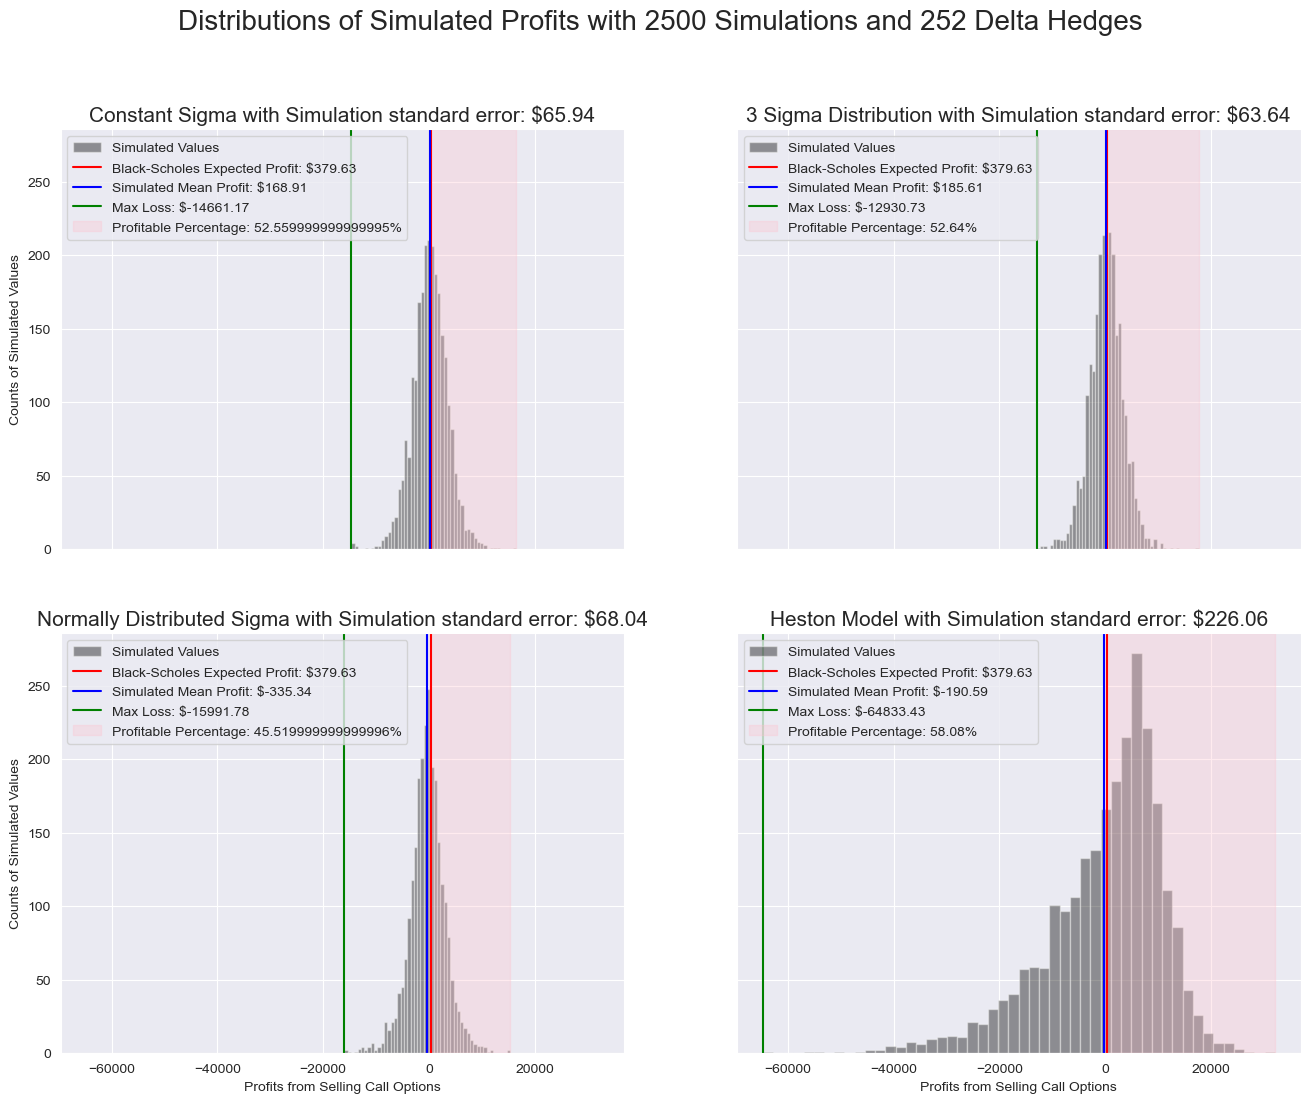

<Figure size 640x480 with 0 Axes>

In [89]:
#Simulate and plot histograms of a seller of 1000 call option contracts that receives a premium above the Black-Scholes Price
S0 = 105 # Initial stock price
K = 100 # Strike price
sigma = .3 # Volatility of stock movement, not constant through all models
t = 1 # Time to expiration in years
r = 0.04 # Risk-free interest rate
mu = .4 #Drift of stock movement
n_sims = 2500 # Number of simulations
n_hedges = 252 # Number of delta hedges through the time period

# Heston parameters
kappa = 4 
theta = .45**2
xi = .5
v0 = sigma**2
rho = -0.05
dt = t / n_hedges

premium = bs_call(S0,K,sigma + .01,t,r) #Increased volatility results in higher price in Black-Scholes model
num_options = 1000 # Number of options sold
bs_price = bs_call(S0,K,sigma,t,r) # Black-Scholes price of the call option

# Constant Sigma Model
paths = stock_path_constant_sigma(S0, t, r, mu, n_sims, n_hedges, sigma) # Simulated stock paths with constant sigma
sold_calls_hedged = bs_MC_call_paths(S0, K, sigma, t, r, paths, n_hedges) # Simulated value from selling a call option with delta hedging
constant_profits_hedged = num_options*(premium - sold_calls_hedged) # Simulated profits from selling all the call options with delta hedging

# 3 Sigmas Model
paths = stock_path_constant_sigma(S0, t, r, mu, n_sims, n_hedges, sigma) # Simulated stock paths with constant sigma
sold_calls_hedged = bs_MC_call_paths(S0, K, sigma, t, r, paths, n_hedges) # Simulated value from selling a call option with delta hedging
sigma3_profits_hedged = num_options*(premium - sold_calls_hedged) # Simulated profits from selling all the call options with delta hedging

# Normally Distributed Sigma Model
paths = stock_path_normal_sigma(S0, t, r, mu, n_sims, n_hedges, sigma) # Simulated stock paths with constant sigma
sold_calls_hedged = bs_MC_call_paths(S0, K, sigma, t, r, paths, n_hedges) # Simulated value from selling a call option with delta hedging
normal_profits_hedged = num_options*(premium - sold_calls_hedged) # Simulated profits from selling all the call options with delta hedging

# Heston Model
kappa = 4
theta = .45**2
xi = .5
v0 = sigma**2
rho = -0.05
paths, vols = heston_path_sim(S0, v0, r, t, n_hedges, kappa, theta, xi, rho, mu, n_sims) # Simulated stock paths under Heston model
sold_calls_hedged = bs_MC_call_paths(S0, K, vols[:,-1], t, r, paths, n_hedges, sig_model='heston') # Simulated value from selling a call option with delta hedging
heston_profits_hedged = num_options*(premium - sold_calls_hedged) # Simulated profits from selling all the call options with delta hedging

# Plotting the simulated paths
fig, ax = plt.subplots(2,2, figsize=(16, 12), sharex=True, sharey=True)

ax[0,0].hist(constant_profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
ax[0,0].axvline(num_options*(premium-bs_price), label = f'Black-Scholes Expected Profit: ${num_options*(premium-bs_price):.2f}', color = 'red')
ax[0,0].axvline(np.mean(constant_profits_hedged), label = f'Simulated Mean Profit: ${np.mean(constant_profits_hedged):.2f}', color = 'blue')
ax[0,0].axvline(np.min(constant_profits_hedged), label = f'Max Loss: ${np.min(constant_profits_hedged):.2f}', color = 'green')
ax[0,0].axvspan(0,np.max(constant_profits_hedged), color='pink', alpha=0.3,\
label = f'Profitable Percentage: {np.mean(constant_profits_hedged>=0)*100}%')
ax[0,0].legend()
ax[0,0].set_title(f'Constant Sigma with Simulation standard error: \${np.std(constant_profits_hedged)/np.sqrt(n_sims):.2f}',size = 15)
ax[0,0].set_ylabel('Counts of Simulated Values')

ax[0,1].hist(sigma3_profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
ax[0,1].axvline(num_options*(premium-bs_price), label = f'Black-Scholes Expected Profit: ${num_options*(premium-bs_price):.2f}', color = 'red')
ax[0,1].axvline(np.mean(sigma3_profits_hedged), label = f'Simulated Mean Profit: ${np.mean(sigma3_profits_hedged):.2f}', color = 'blue')
ax[0,1].axvline(np.min(sigma3_profits_hedged), label = f'Max Loss: ${np.min(sigma3_profits_hedged):.2f}', color = 'green')
ax[0,1].axvspan(0,np.max(sigma3_profits_hedged), color='pink', alpha=0.3,\
label = f'Profitable Percentage: {np.mean(sigma3_profits_hedged>=0)*100}%')
ax[0,1].legend()
ax[0,1].set_title(f'3 Sigma Distribution with Simulation standard error: \${np.std(sigma3_profits_hedged)/np.sqrt(n_sims):.2f}',size = 15)

ax[1,0].hist(normal_profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
ax[1,0].axvline(num_options*(premium-bs_price), label = f'Black-Scholes Expected Profit: ${num_options*(premium-bs_price):.2f}', color = 'red')
ax[1,0].axvline(np.mean(normal_profits_hedged), label = f'Simulated Mean Profit: ${np.mean(normal_profits_hedged):.2f}', color = 'blue')
ax[1,0].axvline(np.min(normal_profits_hedged), label = f'Max Loss: ${np.min(normal_profits_hedged):.2f}', color = 'green')
ax[1,0].axvspan(0,np.max(normal_profits_hedged), color='pink', alpha=0.3,\
label = f'Profitable Percentage: {np.mean(normal_profits_hedged>=0)*100}%')
ax[1,0].legend()
ax[1,0].set_title(f'Normally Distributed Sigma with Simulation standard error: \${np.std(normal_profits_hedged)/np.sqrt(n_sims):.2f}',size = 15)
ax[1,0].set_ylabel('Counts of Simulated Values')
ax[1,0].set_xlabel('Profits from Selling Call Options')

ax[1,1].hist(heston_profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
ax[1,1].axvline(num_options*(premium-bs_price), label = f'Black-Scholes Expected Profit: ${num_options*(premium-bs_price):.2f}', color = 'red')
ax[1,1].axvline(np.mean(heston_profits_hedged), label = f'Simulated Mean Profit: ${np.mean(heston_profits_hedged):.2f}', color = 'blue')
ax[1,1].axvline(np.min(heston_profits_hedged), label = f'Max Loss: ${np.min(heston_profits_hedged):.2f}', color = 'green')
ax[1,1].axvspan(0,np.max(heston_profits_hedged), color='pink', alpha=0.3,\
label = f'Profitable Percentage: {np.mean(heston_profits_hedged>=0)*100}%')
ax[1,1].legend()
ax[1,1].set_title(f'Heston Model with Simulation standard error: \${np.std(heston_profits_hedged)/np.sqrt(n_sims):.2f}',size = 15)
ax[1,1].set_xlabel('Profits from Selling Call Options')

fig.suptitle(f'Distributions of Simulated Profits with {n_sims} Simulations and {n_hedges} Delta Hedges', fontsize=20)
plt.show()
plt.tight_layout()

## Analysis

The constant sigma and the 3 sigma model both give a positive mean profit, which is desirable for selling call options. The other two models predict a negative mean profit, or losing money. However, the Heston model has the highest profitable percentage of the distribution. None have the Black-Scholes expected profit within one standard error of the simulated mean profit. 

Overall, I do not think any of these models worked well.

Future work (beyond adjusting these models to better reflect real world scenarios) would be to implement transaction costs of about $0.65 per option or implementing a the difference between the buy and sell price of the stocks.